# Life Expectancy: Exploratory Data Analysis
Goal: Find a set of features that affect Life Expectancy.
0. Load Data
1. Data Cleaning
    a. Detect problems (nonsense, missing, outliers)
2. Data Exploration
    a. Univariate/Multivariable exploration
3. Feature Engineering
    a. Select ideal variables
    b. Discard unnecessary variables (extra correlated, irrelevant)
4. Summary
    a. Use effective visualization

## Imports and Dataset Load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sqlalchemy import create_engine
import os
import warnings

pd.set_option('display.max_columns', None)

# warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print(pd.__version__)

%matplotlib inline

1.0.3


In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df_source = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
df = df_source.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [5]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Now that the dataset is loaded into the DataFrame, `df`, it is now time to begin the EDA.

# Section 1: Data Cleaning

Time to better understand the variables we are working with.
1. What does the variable mean and what type of variable is it (Nominal/Ordinal/Interval/Ratio)?
2. Does the variable have missing values? If so, what should be done about them?
3. Does the variable have outliers? If so, what should be done about them?

### 1.1: Dataset Description/Variable Descriptions

#### Dataset Description
The dataset is comprised of data from all over the world from various countries aggregated by the World Health Organization (WHO for short). The data is an aggregate of many indicators for a particular country in a particular year. In essence, the data is multiple indicators in a time series separated by country. A more in depth look into the context, content, and acknowledgments for this dataset can be found [here](https://www.kaggle.com/kumarajarshi/life-expectancy-who).

Before getting into the variable descriptions, the string values for the columns/variables themselves are not very 'clean' so the following is a quick cleaning of the column/variable titles.

In [6]:
orig_cols = list(df.columns)
new_cols = []
for col in orig_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
df.columns = new_cols

#### Variable Descriptions
Format: `variable` (type) - description
- `country` (Nominal) - the country in which the indicators are from (i.e. United States of America or Congo)
- `year` (Ordinal) - the calendar year the indicators are from (ranging from 2000 to 2015)
- `status` (Nominal) - whether a country is considered to be 'Developing' or 'Developed' by WHO standards
- `life_expectancy` (Ratio) - the life expectancy of people in years for a particular country and year
- `adult_mortality` (Ratio) - the adult mortality rate per 1000 population (i.e. number of people dying between 15 and 60 years per 1000 population); if the rate is 263 then that means 263 people will die out of 1000 between the ages of 15 and 60; another way to think of this is that the chance an individual will die between 15 and 60 is 26.3%
- `infant_deaths` (Ratio) - number of infant deaths per 1000 population; similar to above, but for infants
- `alcohol` (Ratio) - a country's alcohol consumption rate measured as liters of pure alcohol consumption per capita
- `percentage_expenditure` (Ratio) - expenditure on health as a percentage of Gross Domestic Product (gdp)
- `hepatitis_b` (Ratio) - number of 1 year olds with Hepatitis B immunization over all 1 year olds in population
- `measles` (Ratio) - number of reported Measles cases per 1000 population
- `bmi` (Interval/Ordinal) - average Body Mass Index (BMI) of a country's total population
- `under-five_deaths` (Ratio) - number of people under the age of five deaths per 1000 population
- `polio` (Ratio) - number of 1 year olds with Polio immunization over the number of all 1 year olds in population
- `total_expenditure` (Ratio) - government expenditure on health as a percentage of total government expenditure
- `diphtheria` (Ratio) - Diphtheria tetanus toxoid and pertussis (DTP3) immunization rate of 1 year olds
- `hiv/aids` (Ratio) - deaths per 1000 live births caused by HIV/AIDS for people under 5; number of people under 5 who die due to HIV/AIDS per 1000 births
- `gdp` (Ratio) - Gross Domestic Product per capita
- `population` (Ratio) - population of a country
- `thinness_1-19_years` (Ratio) - rate of thinness among people aged *10-19* (Note: variable should be renamed to *thinness_10-19_years* to more accurately represent the variable)
- `thinness_5-9_years` (Ratio) - rate of thinness among people aged 5-9
- `income_composition_of_resources` (Ratio) - Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
- `schooling` (Ratio) - average number of years of schooling of a population

As stated above it would be useful to change the name of the variable `thinness_1-19_years` to `thinness_10-19_years` as it is a more accurate depiction of what the variable means.

In [7]:
df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

Now that the column names are looking good, let's inspect for other issues.

#### Correcting Developed/Developing Countries
Farther down the EDA, I noticed some countries that should be `Developed` labeled as `Developing` so I took a look at what countries are labeled Developed.

In [8]:
df.loc[df.status == 'Developed'].country.unique()

array(['Australia', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czechia', 'Denmark', 'Slovakia', 'Germany', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Poland',
       'Portugal', 'Romania', 'Singapore', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland',
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America'], dtype=object)

I manually compared it to [this table](https://en.wikipedia.org/wiki/Developed_country#Comparative_table_(2020)) and took all the countries with one or no pending recognition and changed them to Developed as they were all recognized as Developed before the years in this data

In [9]:
# Comparing Developed vs Developing
# In order to do this, we will need to correct the incorrectly labeled countries

incorr_status = ['Canada', 'Chile', 'Estonia', 'Greece', 'Finland', 'France', 'Israel', 'Republic of Korea']

# Loop through and change them to Developed
for i in incorr_status:
    df['status'].loc[df.country == i] = 'Developed'

C:\Users\Kenei\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
# Verify
df.loc[df.status == 'Developed'].country.unique()
# Verified;

array(['Australia', 'Austria', 'Belgium', 'Bulgaria', 'Canada', 'Chile',
       'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Slovakia', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Poland', 'Portugal', 'Republic of Korea', 'Romania', 'Singapore',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America'], dtype=object)

In [11]:
df.describe(include=['O'])

,country,status
count,2938,2938
unique,193,2
top,Nepal,Developing
freq,16,2298


### 1.2: Missing Values

There are few things that must be done concerning missing values:
1. Detection of missing values
    - Find nulls
    - Could a null be signified by anything other than null? Zero values perhaps?
2. Dealing with missing values
    - Fill nulls? Impute or Interpolate
    - Eliminate nulls?

#### 1.2.1: Missing Values Detection

##### Finding possible inexplicit nulls
These nulls would be missing values that aren't necessarily easy to find using the `df.info()` method.
- What values could be null?
- What values could be erroneous?

**Inexplicit Nulls**\
The easiest and quickest method here would be to do a quick `df.describe()` and look at each variable on its own to see if the values make sense given the description of the variable.

In [12]:
df.describe().iloc[:, 1:]

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


Things that may not make sense from above:
- `adult_mortality` of 1? This is likely an error in measurement, but what values make sense here? May need to change to null if under a certain threshold.
- `infant_deaths` and `under-five_deaths` (per 1000 of population) as low as 0? Not quite plausible - I'll mark them as null. On the other end, max of 1800 and 2500 is definitely an outlier.  A lot of infant deaths with a tiny population?  I'll be dropping outliers above 1000.
- `percentage_expenditure` "as a percent of GDP" has outliers around 20k. Unlikely a country is spending 20,000% of their GDP on health, but a large portion of the data is over 300% of GDP, which also seems very high.  Perhaps will take the log.
- `measles` has a max of 212183 out of 1000? Probably a missed decimal point.
- `bmi` of 1 and 87.3? Pretty sure the whole population would not exist if that were the case. A BMI of 15 or lower is seriously underweight and a BMI of 40 or higher is morbidly obese, therefore a large number of these measurements seem unrealistic, unless a large population (pun intended) of people shorter than 5'0" and weigh over 400 lbs.  We might end up dropping the column entirely.
- `gdp` per capita as low as 1.68 (USD) possible? Doubtful - but perhaps values this low are outliers.
- `population` of 34 for an entire country? Hmm...

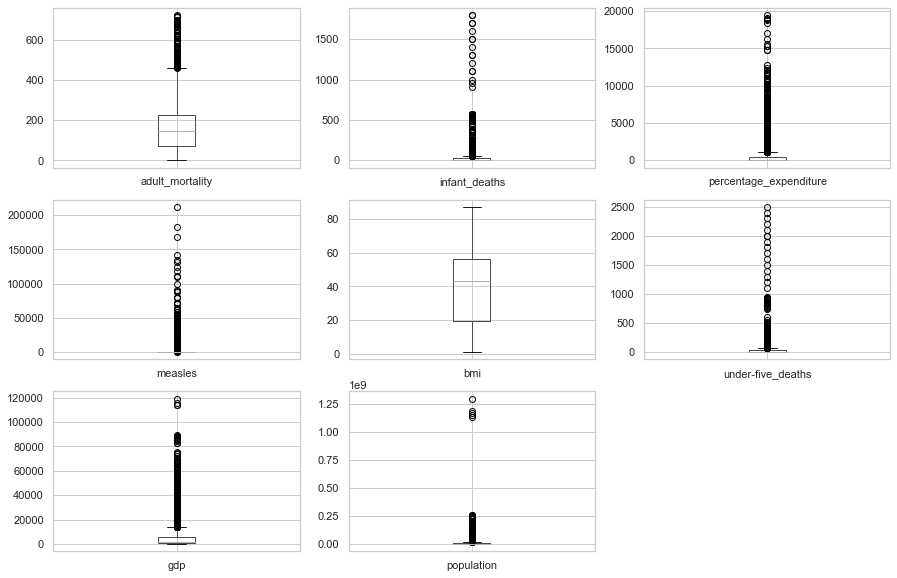

In [13]:
plt.figure(figsize=(15,10))
for i, col in enumerate(['adult_mortality', 'infant_deaths', 'percentage_expenditure', 'measles', 'bmi', 'under-five_deaths', 'gdp', 'population'], start=1):
    plt.subplot(3, 3, i)
    df.boxplot(col)

There are a few of the above that could simply be outliers, but there are some that almost certainly have to be errors of some sort. Of the above variables, changes to null will be made for the following since these numbers don't make any sense:
1. Adult mortality rates lower than the 5th percentile
2. Infant deaths of 0
3. BMI less than 10 and greater than 50
4. Under Five deaths of 0

In [14]:
# Replacing adult_mortality rates lower then 5th percentile with NaN
mort_5_percentile = np.percentile(df.adult_mortality.dropna(), 5)
df.adult_mortality = df.apply(lambda x: np.nan if x.adult_mortality < mort_5_percentile else x.adult_mortality, axis=1)

# Replacing infant_deaths and under-five_deaths with 0 as NaN
df.infant_deaths = df.infant_deaths.replace(0, np.nan)
df['under-five_deaths'] = df['under-five_deaths'].replace(0, np.nan)

#Replacing bmi less than 10 and greater then 50 as NaN
df.bmi = df.apply(lambda x: np.nan if (x.bmi < 10 or x.bmi > 50) else x.bmi, axis=1)

##### All missing values (all explicit now)
###### Percentage

In [15]:
df.isnull().sum()*100/df.isnull().count()

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     5.275698
infant_deaths                      28.863172
alcohol                             6.603131
percentage_expenditure              0.000000
hepatitis_b                        18.822328
measles                             0.000000
bmi                                49.557522
under-five_deaths                  26.718856
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
hiv/aids                            0.000000
gdp                                15.248468
population                         22.191967
thinness_10-19_years                1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

It appears that there are a decent amount of null values, may be of more use to break down the data into those that contain nulls in order to take a closer look. The function below attempts to do just that - it only returns the columns that contain (explicit) nulls, keeps a running total of those columns with nulls as well as their location in the dataframe, returns the count of nulls in a specified column and the percent of nulls out of all the values in the column.

In [16]:
def nulls_breakdown(df=df):
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(
                loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('')
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(
        cols_total_count, cols_count, cols_percent_null))

In [17]:
nulls_breakdown()

[iloc = 3] life_expectancy has 10 null values: 0.34% null
[iloc = 4] adult_mortality has 155 null values: 5.28% null
[iloc = 5] infant_deaths has 848 null values: 28.86% null
[iloc = 6] alcohol has 194 null values: 6.6% null
[iloc = 8] hepatitis_b has 553 null values: 18.82% null
[iloc = 10] bmi has 1456 null values: 49.56% null
[iloc = 11] under-five_deaths has 785 null values: 26.72% null
[iloc = 12] polio has 19 null values: 0.65% null
[iloc = 13] total_expenditure has 226 null values: 7.69% null
[iloc = 14] diphtheria has 19 null values: 0.65% null
[iloc = 16] gdp has 448 null values: 15.25% null
[iloc = 17] population has 652 null values: 22.19% null
[iloc = 18] thinness_10-19_years has 34 null values: 1.16% null
[iloc = 19] thinness_5-9_years has 34 null values: 1.16% null
[iloc = 20] income_composition_of_resources has 167 null values: 5.68% null
[iloc = 21] schooling has 163 null values: 5.55% null

Out of 22 total columns, 16 contain null values; 72.73% columns contain null va

#### 1.2.2: Dealing with Missing Values

Nearly half of the BMI variable's values are null, it is likely best to remove this variable altogether.

In [18]:
df.drop(columns='bmi', inplace=True)

Alright, so it looks like there are a lot of columns containing null values, since this is time series data assorted by country, the best course of action would be to interpolate the data by country. 

In [19]:
df_inter = df.groupby(['country'], sort=False).apply(
    lambda group: group.interpolate(method='linear', limit_direction='both'))

In [20]:
nulls_breakdown(df_inter)

[iloc = 3] life_expectancy has 10 null values: 0.34% null
[iloc = 4] adult_mortality has 10 null values: 0.34% null
[iloc = 5] infant_deaths has 762 null values: 25.94% null
[iloc = 6] alcohol has 17 null values: 0.58% null
[iloc = 8] hepatitis_b has 144 null values: 4.9% null
[iloc = 10] under-five_deaths has 730 null values: 24.85% null
[iloc = 12] total_expenditure has 32 null values: 1.09% null
[iloc = 15] gdp has 405 null values: 13.78% null
[iloc = 16] population has 648 null values: 22.06% null
[iloc = 17] thinness_10-19_years has 34 null values: 1.16% null
[iloc = 18] thinness_5-9_years has 34 null values: 1.16% null
[iloc = 19] income_composition_of_resources has 167 null values: 5.68% null
[iloc = 20] schooling has 163 null values: 5.55% null

Out of 21 total columns, 13 contain null values; 61.9% columns contain null values.


When attempting to interpolate by country it doesn't fill in all values as some countries' data for all the null values are null for each year, therefore imputation by year may be the next best possible method here. Imputation of each year's mean is done below.

In [21]:
imputed_data = []
for year in list(df_inter.year.unique()):
    year_data = df_inter[df_inter.year == year].copy()
    for col in list(year_data.columns)[3:]:
        year_data[col] = year_data[col].fillna(year_data[col].dropna().mean()).copy()
    imputed_data.append(year_data)
df_imputed = pd.concat(imputed_data).copy()

One more look at the null values...

In [22]:
df_imputed.shape

(2938, 21)

In [23]:
nulls_breakdown(df_imputed)


Out of 21 total columns, 0 contain null values; 0.0% columns contain null values.


This method took care of the rest of the null values.

### 1.3: Outliers

Similar to missing values, there are a few things that needs to be done in order to deal with outliers:
1. Detect the outliers
    - Boxplots/histograms
    - Tukey's Method
2. Deal with outliers
    - Drop outliers?
    - Limit/Winsorize outliers?
    - Transform the data using log/inverse/square root/etc?

#### 1.3.1: Outliers Detection

First a boxplot and histogram will be created for each continuous variable in order to visually see if outliers exist.

In [24]:
cont_vars = list(df_imputed.columns)[3:]
def outliers_visual(data):
    plt.figure(figsize=(15, 40))
    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
        plt.subplot(9, 4, i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
    plt.show()

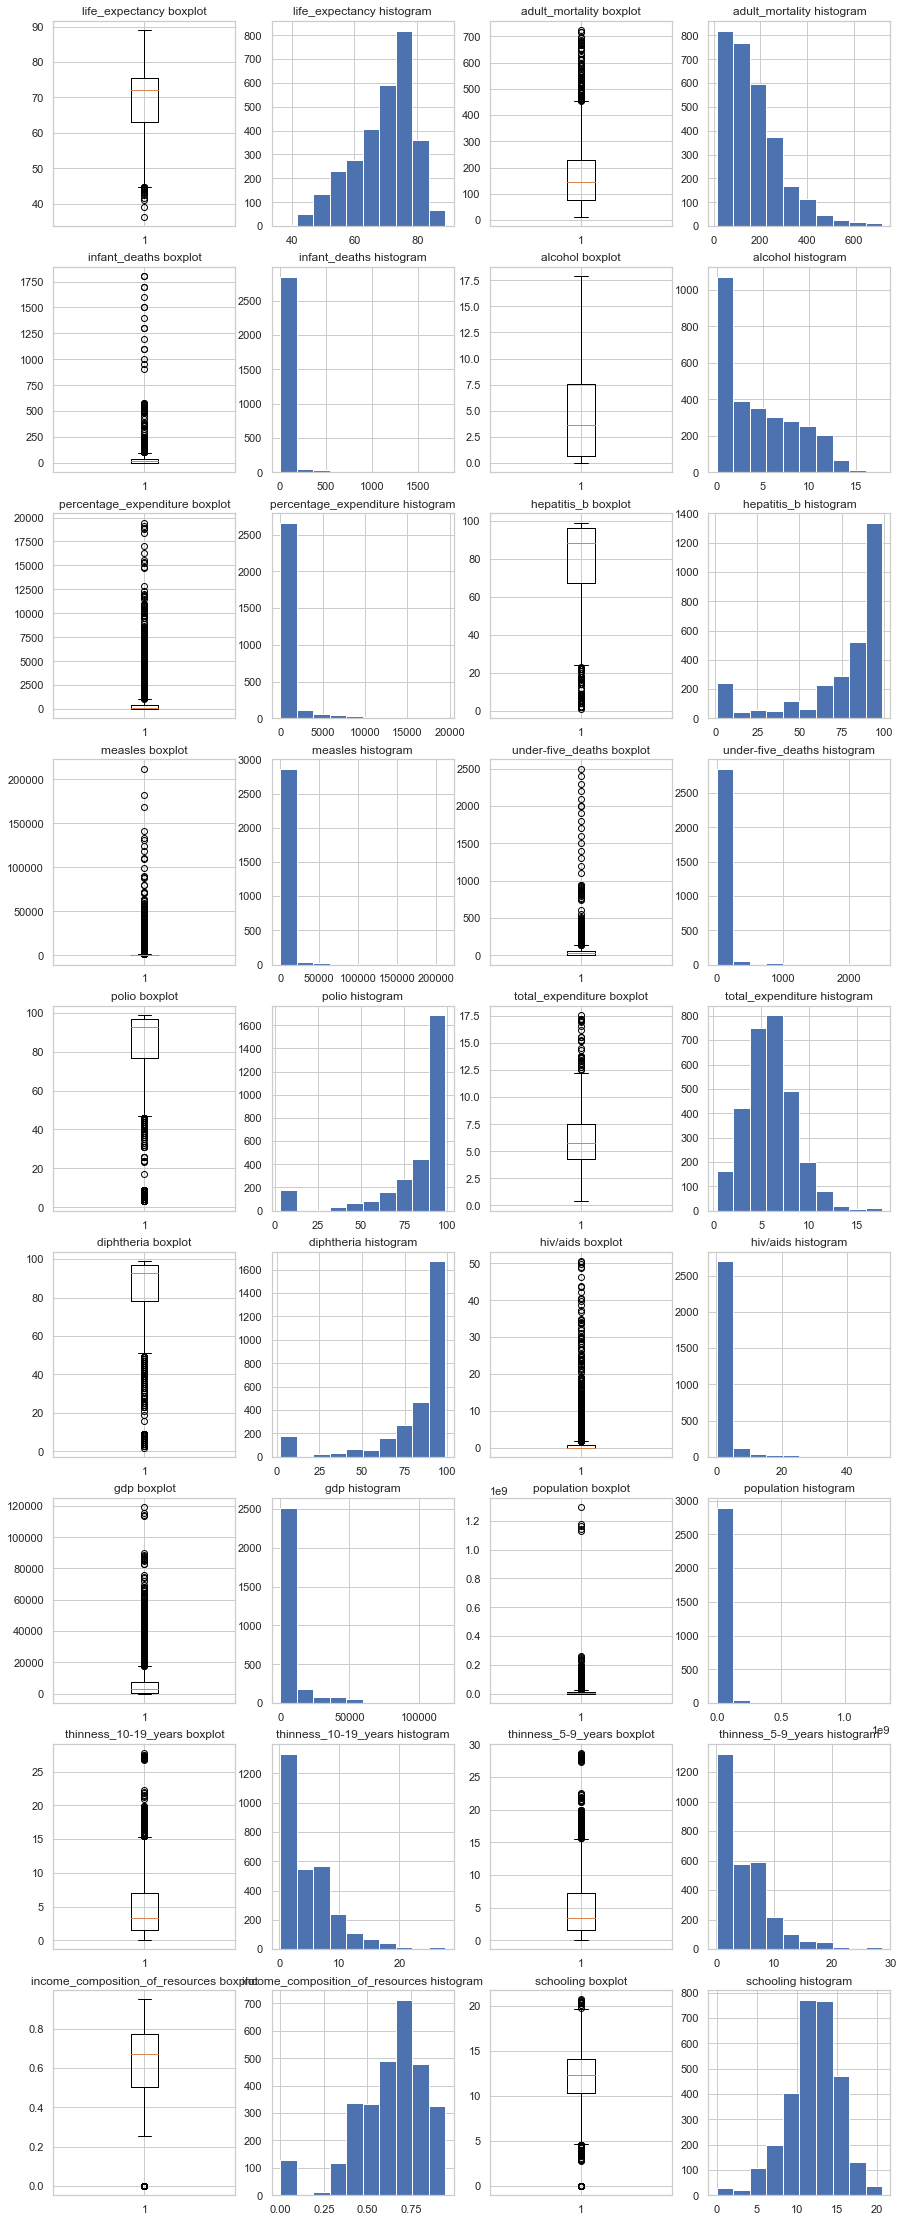

In [25]:
outliers_visual(df_imputed)

Visually, it is plain to see that there are a number of outliers for all of these variables - including the target variable, life expectancy. The same will be done statistically using Tukey's method below - outliers being considered anything outside of 1.5 times the IQR.

In [26]:
def outlier_count(col, data=df_imputed):
    print(15*'-' + col + 15*'-')
    q75, q25 = np.percentile(data[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    print('Number of outliers: {}'.format(outlier_count))
    print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [27]:
for col in cont_vars:
    outlier_count(col)

---------------life_expectancy---------------
Number of outliers: 17
Percent of data that is outlier: 0.58%
---------------adult_mortality---------------
Number of outliers: 87
Percent of data that is outlier: 2.96%
---------------infant_deaths---------------
Number of outliers: 137
Percent of data that is outlier: 4.66%
---------------alcohol---------------
Number of outliers: 0
Percent of data that is outlier: 0.0%
---------------percentage_expenditure---------------
Number of outliers: 389
Percent of data that is outlier: 13.24%
---------------hepatitis_b---------------
Number of outliers: 292
Percent of data that is outlier: 9.94%
---------------measles---------------
Number of outliers: 542
Percent of data that is outlier: 18.45%
---------------under-five_deaths---------------
Number of outliers: 145
Percent of data that is outlier: 4.94%
---------------polio---------------
Number of outliers: 260
Percent of data that is outlier: 8.85%
---------------total_expenditure-------------

It appears there are a decent amount of outliers in this dataset. Now that they have been detected, what should be done with them?

#### 1.3.2: Dealing with Outliers

There are a number of ways to deal with outliers in a dataset, the usual options are as follows:
1. Drop Outliers (best avoided in order to keep as much information as possible)
2. Limit values to upper and/or lower bounds (Winsorize the data)
3. Transform the data (log/inverse/square root/etc.)
    - advantage: can 'normalize' the data and eliminate outliers
    - disadvantage: cannot be done to variables containing values of 0 or below

Since each variable has a unique amount of outliers and also has outliers on different sides of the data, the best route to take is probably winsorizing (limiting) the values for each variable on its own until no outliers remain. The function below allows me to do exactly that by going variable by variable with the ability to use a lower limit and/or upper limit for winsorization. 

By default the function will show two boxplots side by side for the variable (one boxplot of the original data, and one with the winsorized change). Once a satisfactory limit is found (by visual analysis), the winsorized data will be saved in the `wins_dict` dictionary so the data can easily be accessed later.

In [28]:
def test_wins(col, lower_limit=0, upper_limit=0, show_plot=True):
    wins_data = winsorize(df_imputed[col], limits=(lower_limit, upper_limit))
    wins_dict[col] = wins_data
    if show_plot == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.boxplot(df_imputed[col])
        plt.title('original {}'.format(col))
        plt.subplot(122)
        plt.boxplot(wins_data)
        plt.title('wins=({},{}) {}'.format(lower_limit, upper_limit, col))
        plt.show()

In [29]:
wins_dict = {}

In [30]:
test_wins(cont_vars[0], lower_limit=.01, show_plot=False)

In [31]:
test_wins(cont_vars[1], upper_limit=.03, show_plot=False)

In [32]:
test_wins(cont_vars[2], upper_limit=.05, show_plot=False)

In [33]:
test_wins(cont_vars[3], upper_limit=.00, show_plot=False)

In [34]:
test_wins(cont_vars[4], upper_limit=.135, show_plot=False)

In [35]:
test_wins(cont_vars[5], lower_limit=.1, show_plot=False)

In [36]:
test_wins(cont_vars[6], upper_limit=.19, show_plot=False)

In [37]:
test_wins(cont_vars[7], upper_limit=.05, show_plot=False)

In [38]:
test_wins(cont_vars[8], lower_limit=.09, show_plot=False)

In [39]:
test_wins(cont_vars[9], upper_limit=.02, show_plot=False)

In [40]:
test_wins(cont_vars[10], lower_limit=.105, show_plot=False)

In [41]:
test_wins(cont_vars[11], upper_limit=.185, show_plot=False)

In [42]:
test_wins(cont_vars[12], upper_limit=.103, show_plot=False)

In [43]:
test_wins(cont_vars[13], upper_limit=.07, show_plot=False)

In [44]:
test_wins(cont_vars[14], upper_limit=.035, show_plot=False)

In [45]:
test_wins(cont_vars[15], upper_limit=.034, show_plot=False)

In [46]:
test_wins(cont_vars[16], lower_limit=.045, show_plot=False)

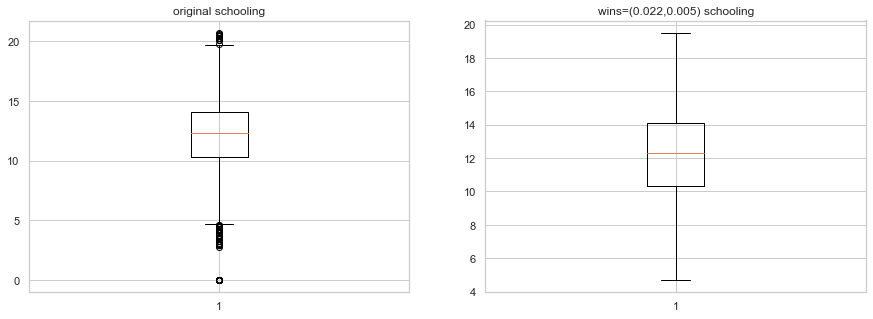

In [47]:
test_wins(cont_vars[17], lower_limit=.022, upper_limit=.005, show_plot=True)

The plot above is an example of how the winsorization is visually inspected (the rest are not shown for brevity).

All the variables have now been winsorized as little as possible in order to keep as much data in tact as possible while still being able to eliminate the outliers. Finally, small boxplots will be shown for each variable's winsorized data to show that the outliers have indeed been dealt with.

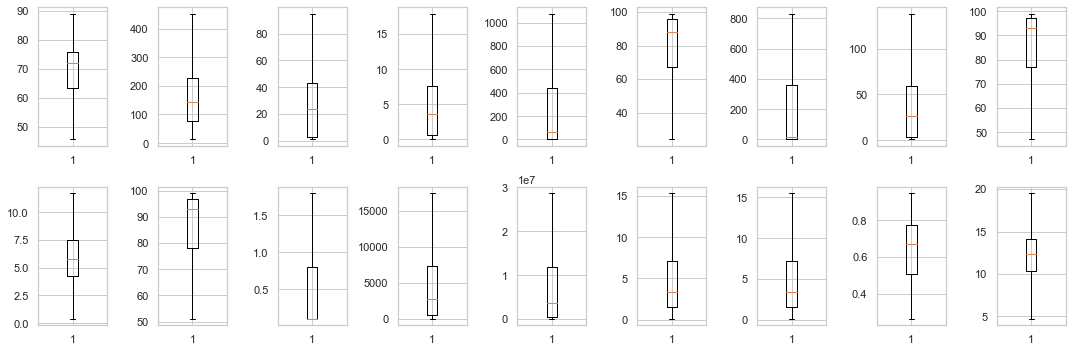

In [48]:
plt.figure(figsize=(15,5))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(2, 9, i)
    plt.boxplot(wins_dict[col])
plt.tight_layout()
plt.show()

Now that the outliers have been dealt with, the data cleaning section is complete.

# Section 2: Data Exploration

Before diving into exploration, a new dataframe with the winsorized data should be created.

In [49]:
wins_df = df_imputed.iloc[:, 0:3]
for col in cont_vars:
    wins_df[col] = wins_dict[col]

In [50]:
wins_df.shape

(2938, 21)

With that out of the way, the main areas of interest in this section are as follows:
1. Univariate Analysis
    - Continuous variables
    - Categorical Variables
2. Bivariate Analysis
    - Continuous to Continuous variables
    - Continuous to Categorical variables
    - Categorical to Categorical variables

### 2.1: Univariate Analysis

Univariate analysis is looking at the data for each variable on its own. This is generally done best by using histograms for continuous data, count/barplots for categorical data and of course by getting the descriptive stats by using `.describe()`.

**Descriptive Statistics**

In [51]:
wins_df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.248795,165.632347,27.081105,4.518139,281.501093,77.351455,220.691287,37.371262,84.900953,5.900695,85.221920,0.526991,4986.424134,7.484094e+06,4.703351,4.720470,0.639239,12.045177
std,4.613841,9.462136,112.117326,25.850486,4.058862,384.161450,24.386092,329.192321,37.899100,16.485858,2.384039,15.606754,0.675962,5558.591540,8.641017e+06,3.925702,3.964268,0.174606,3.096688
min,2000.000000,45.600000,13.000000,1.000000,0.010000,0.000000,24.000000,0.000000,1.000000,47.000000,0.370000,51.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.261000,4.700000
25%,2004.000000,63.200000,78.000000,3.000000,0.642500,4.685343,67.000000,0.000000,4.000000,77.000000,4.270000,78.000000,0.100000,555.356624,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.000000,144.000000,23.500000,3.635000,64.912906,88.000000,17.000000,27.000000,93.000000,5.750000,93.000000,0.100000,2791.697695,3.625718e+06,3.400000,3.400000,0.673000,12.300000
75%,2012.000000,75.600000,228.000000,42.823529,7.600000,441.534144,96.000000,360.250000,58.731884,97.000000,7.470000,97.000000,0.800000,7316.984298,1.181332e+07,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,452.000000,95.000000,17.870000,1077.712092,99.000000,831.000000,138.000000,99.000000,11.700000,99.000000,1.800000,17421.892200,2.865628e+07,15.300000,15.500000,0.948000,19.500000


In [52]:
wins_df.describe(include='O')

,country,status
count,2938,2938
unique,193,2
top,Nepal,Developing
freq,16,2298


**Visual Distributions**

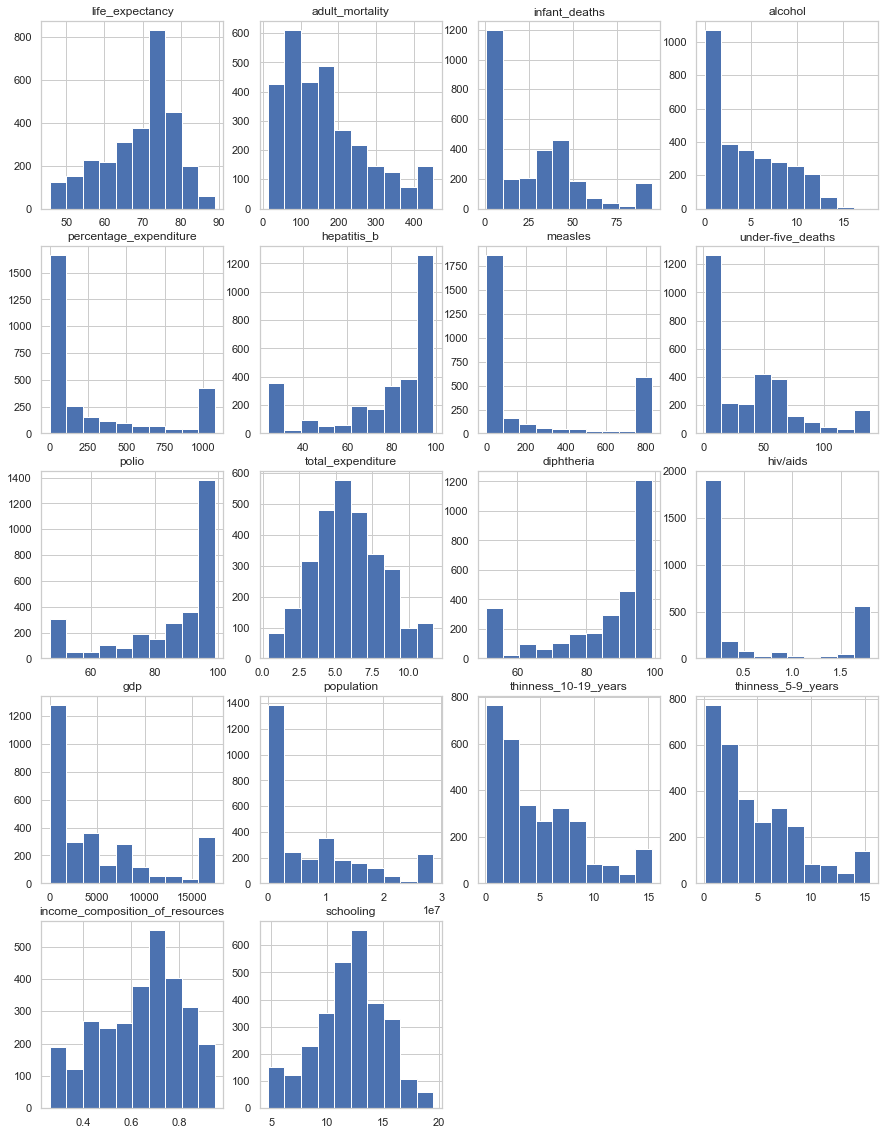

In [53]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(5, 4, i)
    plt.hist(wins_df[col])
    plt.title(col)

The winsorization had a large effect on some variables while not having too much of an effect on others. Even though all of these variables were winsorized in some fashion, some variables are much more obviously winsorized than others. What about the categorical variables, how many of each of these are there in the data (in essence, what is their distribution?)

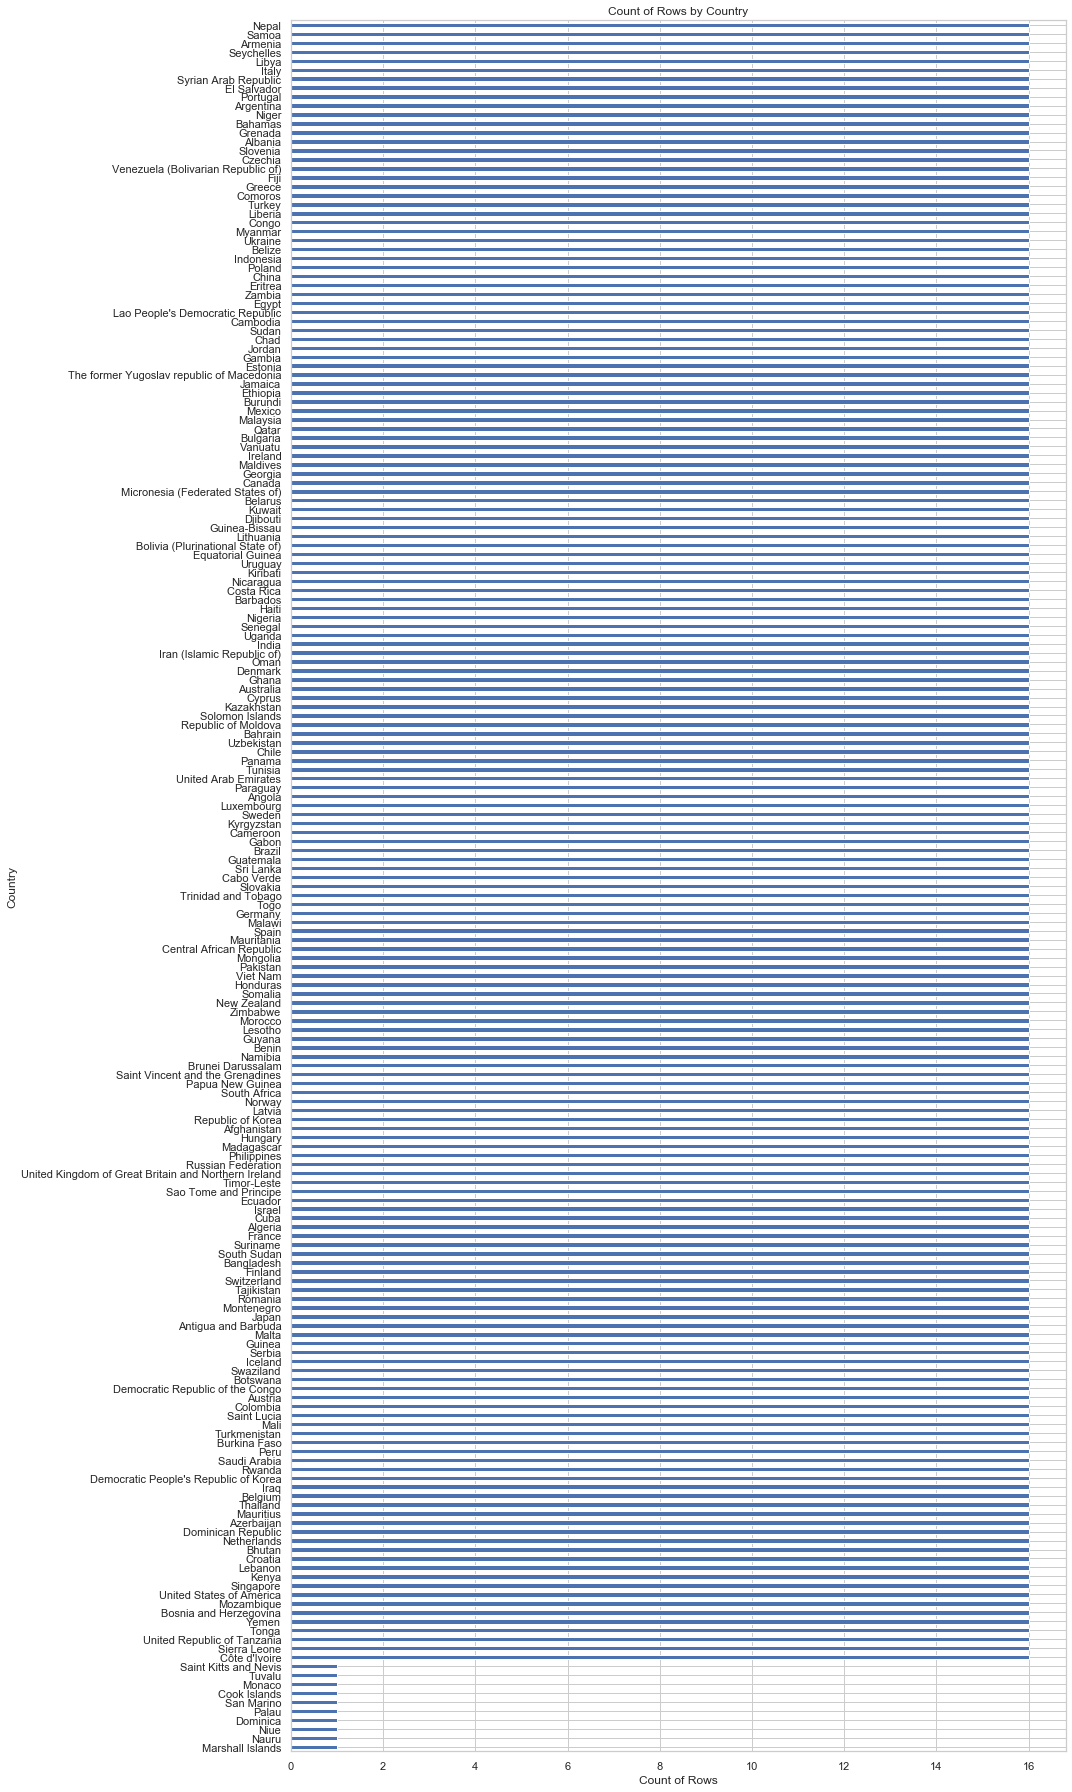

In [54]:
plt.figure(figsize=(15, 25))
wins_df.country.value_counts(ascending=True).plot(kind='barh')
plt.title('Count of Rows by Country')
plt.xlabel('Count of Rows')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

This isn't the most appealing graph, but it displays that the mass majority of countries have 16 rows (16 years) worth of data. This is important to know mostly to make sure that certain countries are not being overrepresented.

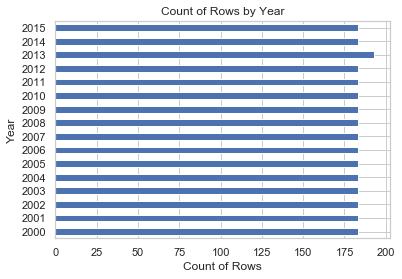

In [55]:
wins_df.year.value_counts().sort_index().plot(kind='barh')
plt.title('Count of Rows by Year')
plt.xlabel('Count of Rows')
plt.ylabel('Year')
plt.show()

Again, not the most useful plot, but does display that each year has the same amount of rows, except for 2013, which contains 10 more rows than the rest (the countries with only one row from the prior graph's data must be from 2013 alone). This shouldn't have a detrimental effect on analysis.

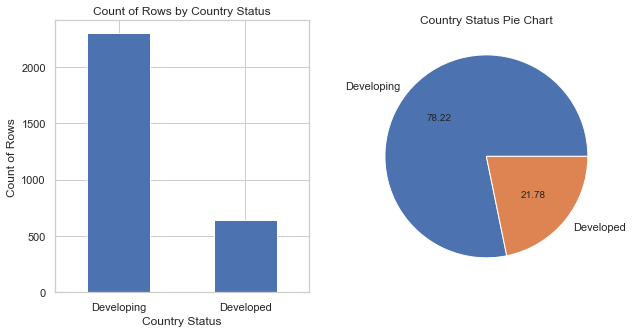

In [56]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
wins_df.status.value_counts().plot(kind='bar')
plt.title('Count of Rows by Country Status')
plt.xlabel('Country Status')
plt.ylabel('Count of Rows')
plt.xticks(rotation=0)

plt.subplot(122)
wins_df.status.value_counts().plot(kind='pie', autopct='%.2f')
plt.ylabel('')
plt.title('Country Status Pie Chart')

plt.show()

This graph, though simple, is important. The above displays that the majority of our data comes from countries listed as 'Developing' - 78.22% to be exact. It is likely that any model used will more accurately depict results for 'Developing' countries over 'Developed' countries as the majority of the data lies within countries that are 'Developing' rather than 'Developed'.

### 2.2: Bivariate Analysis

There are a number of things that should be examined here:
1. Continuous variables compared to the life expectancy (target variable) and to one another
2. Categorical variables compared to the life expectancy (target variable)
3. Comparison of Country Status and Year to Continuous variables (country has an extremely large number of values with small sample sizes, so country comparisons aren't especially helpful for this dataset)

#### 2.2.1: Continuous to Continuous Analysis

In [57]:
wins_df[cont_vars].corr()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
life_expectancy,1.000000,-0.701819,-0.265798,0.399757,0.488440,0.328589,-0.337887,-0.322638,0.563389,0.235547,0.578788,-0.796939,0.515735,0.012278,-0.514966,-0.512694,0.784053,0.741470
adult_mortality,-0.701819,1.000000,0.152893,-0.200661,-0.318534,-0.203865,0.218821,0.188649,-0.355085,-0.140778,-0.366789,0.612311,-0.331038,0.001880,0.347446,0.352848,-0.520600,-0.468398
infant_deaths,-0.265798,0.152893,1.000000,-0.100469,-0.132212,-0.196667,0.356873,0.979956,-0.249627,-0.100590,-0.263195,0.157117,-0.097586,0.201960,0.227832,0.234391,-0.223875,-0.241369
alcohol,0.399757,-0.200661,-0.100469,1.000000,0.387347,0.091947,-0.193923,-0.128632,0.267433,0.302420,0.276335,-0.198184,0.409384,-0.033763,-0.443484,-0.434123,0.472883,0.522059
percentage_expenditure,0.488440,-0.318534,-0.132212,0.387347,1.000000,0.096278,-0.194687,-0.144073,0.263405,0.176500,0.268475,-0.295791,0.731166,-0.068679,-0.331693,-0.333748,0.549699,0.529213
hepatitis_b,0.328589,-0.203865,-0.196667,0.091947,0.096278,1.000000,-0.236997,-0.215989,0.573908,0.107286,0.639677,-0.313169,0.134330,0.016524,-0.151046,-0.160171,0.298081,0.300494
measles,-0.337887,0.218821,0.356873,-0.193923,-0.194687,-0.236997,1.000000,0.388123,-0.305669,-0.157926,-0.304404,0.226305,-0.185635,0.223280,0.359571,0.364201,-0.268910,-0.328525
under-five_deaths,-0.322638,0.188649,0.979956,-0.128632,-0.144073,-0.215989,0.388123,1.000000,-0.292429,-0.110130,-0.305094,0.214628,-0.127068,0.190996,0.253026,0.254227,-0.279238,-0.291576
polio,0.563389,-0.355085,-0.249627,0.267433,0.263405,0.573908,-0.305669,-0.292429,1.000000,0.174679,0.846450,-0.465421,0.320943,0.008897,-0.279125,-0.277857,0.507079,0.509319
total_expenditure,0.235547,-0.140778,-0.100590,0.302420,0.176500,0.107286,-0.157926,-0.110130,0.174679,1.000000,0.184678,-0.121400,0.157248,-0.100758,-0.293425,-0.303686,0.195337,0.273971


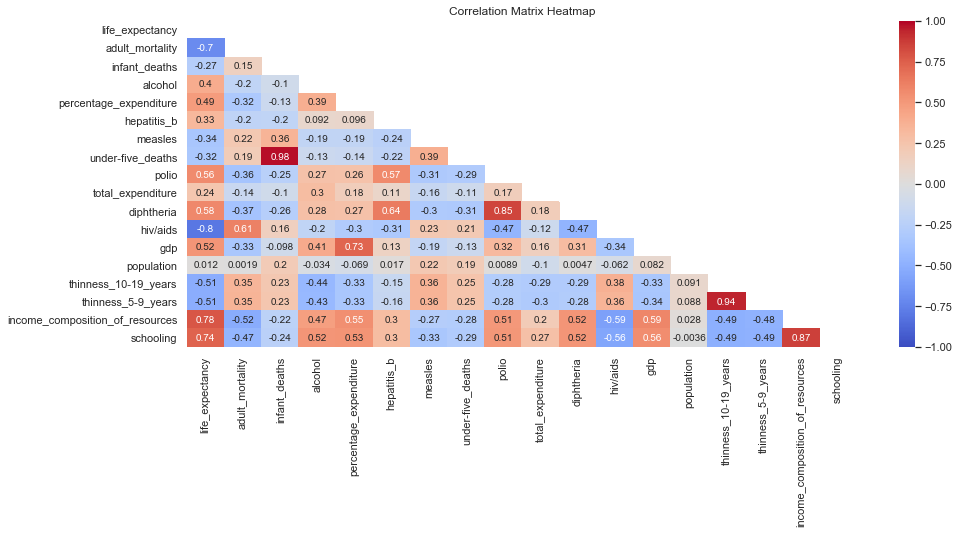

In [58]:
mask = np.triu(wins_df[cont_vars].corr())
plt.figure(figsize=(15,6))
sns.heatmap(wins_df[cont_vars].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

Note: the values above show rounding at the final two digits, for more exact values, reference the correlation matrix.

The above heatmap is very useful! It very easily displays a number of important correlations between variables. Some general takeaways from the graphic above:
- Life Expectancy (target variable) appears to be relatively highly correlated (negatively or positively) with:
    - Adult Mortality (negative)
    - HIV/AIDS (negative)
    - Income Composition of Resources (positive)
    - Schooling (positive)
- Life expectancy (target variable) is extremely lowly correlated to population (nearly no correlation at all)
- Infant deaths and Under Five deaths are extremely highly correlated
- Percentage Expenditure and GDP are relatively highly correlated
- Hepatitis B vaccine rate is relatively positively correlated with Polio and Diphtheria vaccine rates
- Polio vaccine rate and Diphtheria vaccine rate are very positively correlated
- HIV/AIDS is relatively negatively correlated with Income Composition of Resources
- Thinness of 5-9 Year olds rate and Thinness of 10-15 Year olds rate is extremely highly correlated
- Income Composition of Resources and Schooling are very highly correlated

*Looking ahead: after combining/removing variables that are very highly or extremely highly correlated with one another as well as variables that are very lowly correlated with one another, the best course of action may be to perform dimensionality reduction using PCA in the feature engineering stage.*

#### 2.2.2: Categorical to Life Expectancy Comparison

First, looking at how life expectancy has changed over the years may be helpful.

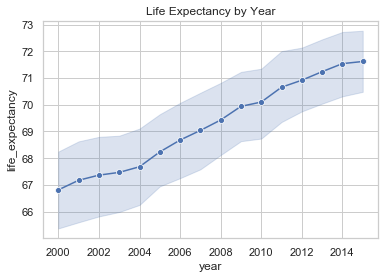

In [59]:
sns.lineplot('year', 'life_expectancy', data=wins_df, marker='o')
plt.title('Life Expectancy by Year')
plt.show()

There appears to definitely be a positive trend over time, but is 15 years of data enough to make the year relevant to a model?

In [60]:
wins_df.year.corr(wins_df.life_expectancy)

0.16979644964459023

There definitely appears to be a correlation, but are the differences between the years significant enough to be considered different? A t-test comparison will be used to find out.

In [61]:
years = list(wins_df.year.unique())
years.sort()

In [62]:
yearly_le = {}
for year in years:
    year_data = wins_df[wins_df.year == year].life_expectancy
    yearly_le[year] = year_data

In [63]:
for year in years[:-1]:
    print(10*'-' + str(year) + ' to ' + str(year+1) + 10*'-')
    print(stats.ttest_ind(yearly_le[year], yearly_le[year+1], equal_var=False))

----------2000 to 2001----------
Ttest_indResult(statistic=-0.339874273786677, pvalue=0.734147249286317)
----------2001 to 2002----------
Ttest_indResult(statistic=-0.18288775743069652, pvalue=0.8549879128960569)
----------2002 to 2003----------
Ttest_indResult(statistic=-0.09788073999943862, pvalue=0.922080868750695)
----------2003 to 2004----------
Ttest_indResult(statistic=-0.20076791323205204, pvalue=0.8409921852108724)
----------2004 to 2005----------
Ttest_indResult(statistic=-0.5360239830703207, pvalue=0.5922696887371386)
----------2005 to 2006----------
Ttest_indResult(statistic=-0.43512464639644277, pvalue=0.6637298353979988)
----------2006 to 2007----------
Ttest_indResult(statistic=-0.35499521065847695, pvalue=0.7227988446996725)
----------2007 to 2008----------
Ttest_indResult(statistic=-0.39657900568183463, pvalue=0.6919107746155075)
----------2008 to 2009----------
Ttest_indResult(statistic=-0.5367008466564068, pvalue=0.5918023223783456)
----------2009 to 2010----------
T

Based on the above t-tests, year to year the differences between Life Expectancy do not appear to be significant.

What about status? There is definitely a difference in the amount of count of values between these two variables (found in the prior univariate analysis), but how about the difference between them with respect to Life Expectancy?

In [64]:
wins_df.groupby('status').life_expectancy.agg(['mean'])

,mean
status,
Developed,79.408750
Developing,66.419217


It appears that 'Developed' countries have a much higher average Life Expectancy. But similar to the year comparisons above, is this difference significant? Again, a t-test comparison will be used to find out.

In [65]:
developed_le = wins_df[wins_df.status == 'Developed'].life_expectancy
developing_le = wins_df[wins_df.status == 'Developing'].life_expectancy
stats.ttest_ind(developed_le, developing_le, equal_var=False)

Ttest_indResult(statistic=55.30210342761432, pvalue=0.0)

Based on the result of the above t-test, there appears to be a very significant difference between 'Developing' and 'Developed' countries with respect to their Life Expectancy. Since this is the case, a comparison between the status variable and all other continuous variables should be made before moving to the feature engineering phase.

#### 2.2.3: Status Variable Compared to other Continuous Variables

Since the status variable only contains two different values, it is likely best to compare a number of descriptive statistics for those two values with respect to all the other continuous variables.

In [66]:
wins_df_cols = list(wins_df.columns)
interested_vars = [wins_df_cols[2]]
for col in wins_df_cols[4:]:
    interested_vars.append(col)

In [67]:
wins_df[interested_vars].groupby('status').agg('mean')

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
status,,,,,,,,,,,,,,,,,
Developed,86.171875,22.001149,9.397531,628.562325,80.971209,123.243750,28.373958,94.090625,7.395000,94.36875,0.100000,10435.152437,6.556472e+06,1.268750,1.230937,0.830199,15.458947
Developing,187.762330,28.495888,3.159213,184.843483,76.343342,247.830722,39.877039,82.341601,5.484527,82.67450,0.645909,3468.936704,7.742439e+06,5.659897,5.692315,0.586057,11.094432


From the above, it appears that many of these values are likely correlated to whether a country is 'Developed' or 'Developing'. Again, t-tests are the best way to find out if differences are significant here.

In [68]:
developed_df = wins_df[wins_df.status == 'Developed']
developing_df = wins_df[wins_df.status == 'Developing']
for col in interested_vars[1:]:
    print(5*'-' + str(col) + ' Developed/Developing t-test comparison' + 5*'-')
    print('p-value=' +str(stats.ttest_ind(developed_df[col], developing_df[col], equal_var=False)[1]))

-----adult_mortality Developed/Developing t-test comparison-----
p-value=6.102725554897427e-221
-----infant_deaths Developed/Developing t-test comparison-----
p-value=2.501386858987385e-11
-----alcohol Developed/Developing t-test comparison-----
p-value=4.044054815042072e-232
-----percentage_expenditure Developed/Developing t-test comparison-----
p-value=5.767528120973781e-89
-----hepatitis_b Developed/Developing t-test comparison-----
p-value=4.624926886567608e-06
-----measles Developed/Developing t-test comparison-----
p-value=1.1230738692829302e-24
-----under-five_deaths Developed/Developing t-test comparison-----
p-value=8.513615263975946e-17
-----polio Developed/Developing t-test comparison-----
p-value=8.497744577360975e-123
-----total_expenditure Developed/Developing t-test comparison-----
p-value=1.839997842127803e-54
-----diphtheria Developed/Developing t-test comparison-----
p-value=7.205857654851718e-137
-----hiv/aids Developed/Developing t-test comparison-----
p-value=1.362

From the above, it is plain to see that there is a significant difference between the following variables with respect to a country's status:
- Adult Mortality
- Alcohol
- Percentage Expenditure
- Hepatitis B
- Measles
- Under Five Deaths
- Polio
- Total Expenditure
- Diphtheria
- HIV/AIDS
- GDP
- Population
- Thinness of 10 to 19 Year Olds
- Thinness of 5 to 9 Year Olds
- Income Composition of Resources
- Schooling

This implies that the status of a country is likely highly correlated to the above variables - also from earlier, it is significant in the difference between Life Expectancy as well. This variable should likely be included in our features in the next section. 

And now that the main comparisons have been made between all the relevant variables, it is now time to move on to the feature engineering phase of the EDA.

# Section 3: Feature Engineering

First off, since it is apparent that the status of a country should be included in some way in the final features of the data, one hot encoding will be conducted in order to include it in the future model.

In [69]:
feat_df = wins_df.join(pd.get_dummies(wins_df.status)).drop(columns='status').copy()

In [70]:
feat_df.iloc[:, 2:].corr().iloc[:, -2:].T

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling,Developed,Developing
Developed,0.56675,-0.374082,-0.103724,0.634527,0.476849,0.078348,-0.156246,-0.125306,0.294223,0.330837,0.309348,-0.333415,0.517391,-0.056662,-0.461793,-0.464615,0.57726,0.58187,1.0,-1.0
Developing,-0.56675,0.374082,0.103724,-0.634527,-0.476849,-0.078348,0.156246,0.125306,-0.294223,-0.330837,-0.309348,0.333415,-0.517391,0.056662,0.461793,0.464615,-0.57726,-0.58187,-1.0,1.0


From the above it can be observed that whether a country is 'Developed' or not is certainly correlated with a number of variables, but not extremely highly. However, it does have a very low correlation with Infant Deaths, Under Five Deaths and Population.

Next, the categorical columns, 'year' and 'country' will be dropped as they don't have significant differences among life expectancy.

In [71]:
feat_df.drop(columns=['country', 'year'], inplace=True)

From the prior analysis, there are a number of variables that are very or extremely highly correlated with one another. In those cases, the variable which is most highly correlated to Life Expectancy (target variable) will be kept while the others will be dismissed.

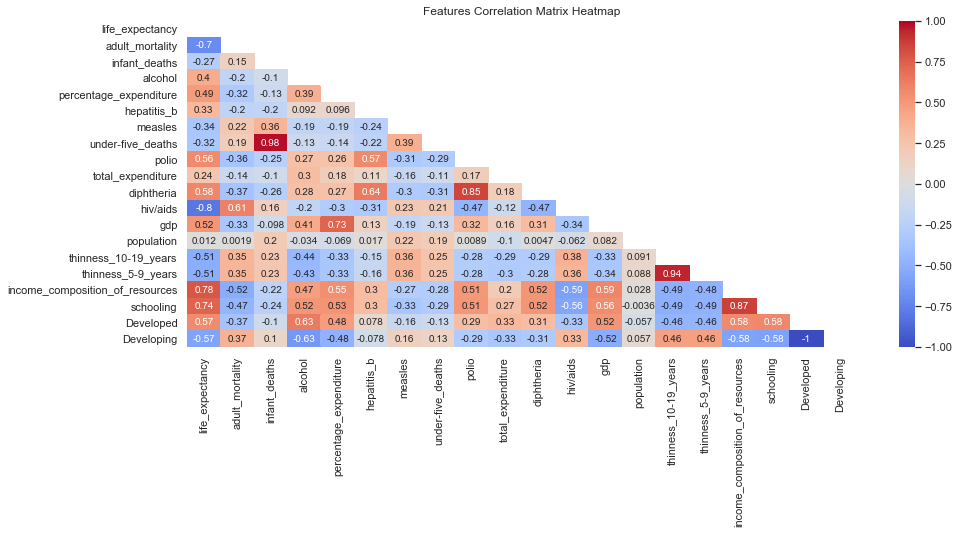

In [72]:
def feat_heatmap():
    mask = np.triu(feat_df.corr())
    plt.figure(figsize=(15,6))
    sns.heatmap(feat_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
    plt.ylim(len(feat_df.columns), 0)
    plt.title('Features Correlation Matrix Heatmap')
    plt.show()
feat_heatmap()

The following are very/extremely highly correlated (correlation > .7 or correlation < -.7):
- Infant Deaths/Under Five Deaths (drop Infant Deaths - Under Five Deaths is more highly correlated to Life Expectancy)
- GDP/Percentage Expenditure (drop Percentage Expenditure - GDP is more higher correlated to Life Expectancy)
- Polio/Diphtheria (drop Polio - Diphtheria is more highly correlated to Life Expectancy)
- Thinness 5-9/Thinness 10-19 (drop Thinness 10-19 as correlations to other variables are slightly higher)
- Income Composition of Resources/Schooling (drop Schooling - Income Composition of Resources is more highly correlated with Life Expectancy)
- Developing/Developed (drop Developing - these two are the same just opposite of one another)

In [73]:
feat_df.drop(columns=['infant_deaths', 'percentage_expenditure','polio','thinness_10-19_years','schooling','Developing'], inplace=True)

In addition to the above variables, it may also be useful to drop variables which are not very correlated with any of the other variables, the only variable where that is the case is 'Population'.

In [74]:
feat_df.drop(columns=['population'], inplace=True)

Another look at the correlation heatmap...

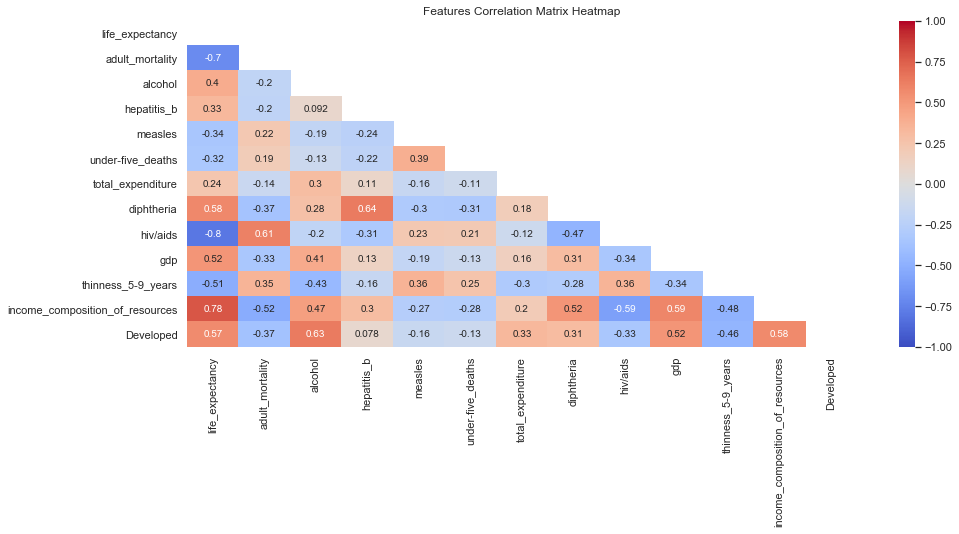

In [75]:
feat_heatmap()

#### Did someone say PCA?

It may be useful to run a Principal Components Analysis (PCA) on this data to reduce the amount of dimensions (features). But there are a number of assumptions/requirements when it comes to PCA:
- Continuous data: the data used should be of a continuous type
- Sample size: the sample size should have between 5-10 samples per feature
- Normalized data: the data is generally normally distributed
- Correlation: there should be correlation between the features
- Linearity: it is assumed that relationships between features are linear
- Outliers: PCA is sensitive to outliers, therefore outliers should not be present

The features set currently satisfies 3 of the above assumptions: sample size, correlation, outliers. The linearity assumption may not be true, the data is not currently normalized and not all the data is continuous - the developed indicator is categorical. First the 'Developed' variable should be removed.

In [76]:
pca_df = feat_df.drop(columns='Developed').copy()

PCA is an unsupervised technique so the target variable is not needed and can be dropped.

In [77]:
pca_df.drop(columns='life_expectancy', inplace=True)

In [78]:
len(pca_df.columns)

11

In [79]:
X = scale(pca_df)
sklearn_pca = PCA()
Y = sklearn_pca.fit_transform(X)
print('Explained variance by Principal Components:', sklearn_pca.explained_variance_ratio_)
print('Eigenvalues:', sklearn_pca.explained_variance_)

Explained variance by Principal Components: [0.37154593 0.120591   0.10570819 0.08660183 0.07408132 0.05761261
 0.05185656 0.04371818 0.03481811 0.02797656 0.02548971]
Eigenvalues: [4.0883968  1.32695262 1.16318601 0.95294451 0.815172   0.63395443
 0.57061643 0.48106371 0.38312958 0.30784695 0.28048228]


In order to capture at least 90% of the variance, 8 components would still be needed, only reducing the amount of features by 3. This is with the assumption that the variables are linearly related as well. If the components with explained variance of one or greater are used (generally not the greatest idea - especially if explanation for variance isn't especially high for those components), then it would be down to three principal components. What does the scree plot have to say?

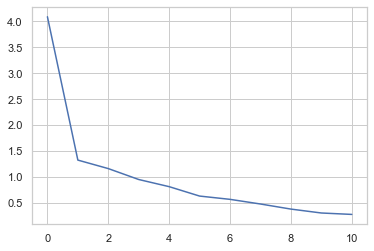

PC1 Explained Variance: 37.15%


In [80]:
plt.plot(sklearn_pca.explained_variance_)
plt.show()
print('PC1 Explained Variance:', str(round(sklearn_pca.explained_variance_ratio_[0]*100, 2))+'%')

Based on the scree plot above, it would suggest that only PC1 be kept, this is likely not a great idea as PC1 only accounts for 37.15% of the total variance of the variables.

#### In this case, perhaps more features > less features

Ultimately, I would probably start modeling using the features prior to the PCA method. Those features are as follows:
1. Adult Mortality
2. Alcohol
3. Hepatitis B
4. Measles
5. Under-Five Deaths
6. Total Expenditure
7. Diphtheria
8. HIV/AIDS
9. GDP
10. Thinness 5-9 Years
11. Income Composition Of Resources
12. Developed

*Note: it may be of use to normalize many of these variables' values, that all depends on the model - the above is simply a good start and easily explainable.*

All of the above variables contain a seemingly meaningful correlation to the target variable (Life Expectancy) while also not being overly correlated with one another.

The reason more variables have not been removed is because there doesn't seem to be a good reason for further removal. Ultimately, keeping more indicators is likely better as long as they are unique enough from one another (and there isn't an overabundance of them).

# Section 4: In Summary

In summation: 

- The dataset started with 21 unclean variables (including the target) 
- Pared down to 12 features to describe the target variable (Life Expectancy)

It's only the beginning as a solid foundation for modeling. The following is a general overview of what was done:

### Cleaning the Data


The first step was to clean the data, this included detecting and dealing with both missing values and outliers. The variables and dataset were given a general description so that a better understanding of what the variables mean could be gathered. Then both explicit and inexplicit missing values were detected. Inexplicit missing values were values that didn't make sense for a variable given the nature of the data. There were a number of seemingly nonsensical values found given many variables' descriptions. Those inexplicit missing values were then converted to explicit missing values or nulls. Interpolation would have likely been the best method to deal with the now explicit null values (since it is time series data), but interpolation in this case would not have garnered any results. Therefore, the next best thing was done instead, imputation based on the means of all countries by year. Once missing values were sorted, the next step was detecting and dealing with outliers. Extreme value detection was done primarily by using standard box and whisker plots with a standard IQR threshold of 1.5. Using this technique, each variable's data was winsorized on a one by one basis to eliminate outliers while limiting the loss of data. Once this step was complete, exploration of the data could be conducted.

The now clean dataset was then analyzed using univariate and bivariate techniques. One of the univariate techniques used was to inspect continuous variables using histograms in order to get an idea of their distributions. The general descriptive statistics were also found for the continuous variables. After that, categorical count plots were created to get an idea of the 'distribution' of categorical data. From that analysis it was discovered that the majority of the data fell under the 'Developing' country status. With the univariate analysis complete, it was time to move on to bivariate analysis. Bivariate analysis definitely laid most of the groundwork for understanding the relationships not only between the target variable (Life Expectancy) and the other variables, but also every variable compare to one another. The primary method used in the bivariate analysis was by the use of the correlation matrix in conjunction with the heatmap visual from the Seaborn library. This took care of the main comparisons between continuous to continuous data and was the main foundation for feature selection. But before moving on to feature engineering, some categorical variables were compared to the target variable. It was found that 'Life Expectancy' with respect to year did not garner significant enough difference to use in analysis. However, it was found that the 'Status' of a country did have a significant effect on 'Life Expectancy'. In addition to 'Life Expectancy' it also appeared to be significantly different for a number of other continuous variables. It is for this reason that new indicator variables, 'Developed' and 'Developing', were created in the next section, feature engineering.

Finally, feature engineering. First, the categorical variables 'Year' and 'Country' were removed as they didn't provide significant differences between data. Then with a general understanding of the variables and the relationship of those variables to one another, it was relatively simple to remove a number of 'highly correlated to one another' variables. The primary method was to use the correlation matrix heatmap in order to detect variables that were highly correlated to another, then from those pairs keep the variable which was more highly correlated with the target. Using this method, the number of variables has been dropped from 20 down to 12 features. The dimensionality reduction method of PCA was used, but didn't seem to garner very useful results. Ultimately, the features kept were those prior to the operation of PCA. It is likely that further transformation of the features should be done, but without knowing which model will be used this set of basic features appears to be the best and most representative set for the target variable of 'Life Expectancy'. With that being said, below is the final heatmap for all the features ultimately selected above (as well as the target variable).

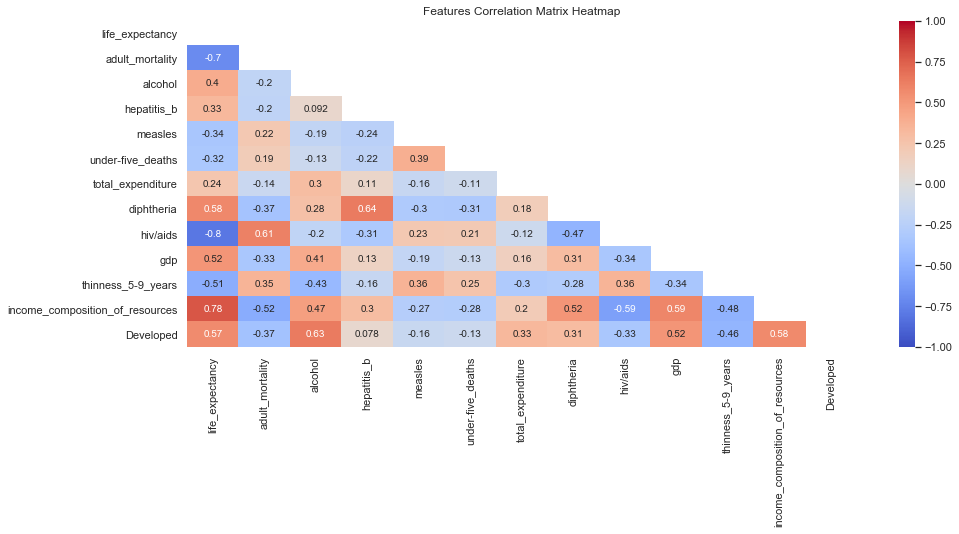

In [81]:
feat_heatmap()